In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('style.mcstyle')

In [3]:
import torch
from torch import nn
import sbi
from sbi import utils as utils
from sbi.inference import likelihood_estimator_based_potential

In [4]:
from tools.catalog import Catalog
from tools.plot_tools import binned_plot
get_cen = lambda edges: np.array([(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)])

# Andrea Flagship 2 data

In [5]:
data = pd.read_csv('data/raw/deep_all.dat', delimiter=' ', index_col=False,
                   skipinitialspace=True)
data = pd.DataFrame(data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)

/var/folders/_t/p68l7m6933b26j8g9wkcgq080000gp/T/ipykernel_41108/851058082.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/raw/deep_all.dat', delimiter=' ', index_col=False,


In [6]:
c = 2.99792458e5 # km/s
data['vwC50'] = c*(data['zwerr']-data['zwC50'])/(1+data['zwC50'])
data['vwC100'] = c*(data['zwerr']-data['zwC100'])/(1+data['zwC100'])
data['vdC50'] = c*(data['zwerr']-data['zdC50'])/(1+data['zwC50'])
data['vdC100'] = c*(data['zwerr']-data['zdC100'])/(1+data['zwC100'])

In [7]:
def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0), [len(x)]]
    return np.concatenate(feats)

def process_and_save(
    data,
    vname,
    fHa_min,
    dirpath,
    vmin=5000,
    param_names=['M200'],
):
    # mask out high velocity, low fHa data
    mask = np.abs(data[vname]) < vmin
    mask &= data['fHa'] > np.log10(fHa_min)

    # get data
    data_names = ['x','y',vname]
    ids = data.loc[mask,'Cl_id'].values.astype(int)
    gals = data.loc[mask, data_names].values.astype('float64')
    thetas = np.log10(data.loc[mask, param_names].values.astype('float64'))

    # remove singles
    unq, cnt = np.unique(ids, return_counts=True)
    mask = np.isin(ids, unq[cnt>1])
    ids, gals, thetas = ids[mask], gals[mask], thetas[mask]

    # calculate batches
    ids_batch = np.unique(ids)
    x_batch = np.array([gals[ids==i] for i in ids_batch], dtype=object)
    thetas_batch = np.array([thetas[ids==i][0] for i in ids_batch])

    # calculate summaries
    x_sum = np.array([calc_sum(x) for x in x_batch])


    # assign folds
    folddict = pd.Series(np.random.choice(10, size=len(ids_batch)), 
                         index=ids_batch)
    folds = folddict[ids].values

    # make train/test splits
    fold = 0
    mask = folds != fold

    # save
    os.makedirs(dirpath, exist_ok=True)
    np.save(join(dirpath, f'x_train.npy'), gals[mask])
    np.save(join(dirpath, f'x_test.npy'), gals[~mask])
    np.save(join(dirpath, f'theta_train.npy'), thetas[mask])
    np.save(join(dirpath, f'theta_test.npy'), thetas[~mask])

    np.save(join(dirpath, f'ids_train.npy'), ids[mask])
    np.save(join(dirpath, f'ids_test.npy'), ids[~mask])
    np.save(join(dirpath, f'folds.npy'), folds)

    mask = folddict[ids_batch].values != fold
    np.save(join(dirpath, f'x_batch_train.npy'), x_batch[mask])
    np.save(join(dirpath, f'x_batch_test.npy'), x_batch[~mask])
    np.save(join(dirpath, f'x_sum_train.npy'), x_sum[mask])
    np.save(join(dirpath, f'x_sum_test.npy'), x_sum[~mask])
    np.save(join(dirpath, f'theta_batch_train.npy'), thetas_batch[mask])
    np.save(join(dirpath, f'theta_batch_test.npy'), thetas_batch[~mask])

    return gals, thetas, x_batch, x_sum, thetas_batch


In [8]:
# Wide survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vwC50',
    fHa_min=2e-16,
    dirpath='data/processed/FS2wC50',
)
print(gals.shape)

(24120, 3)


In [9]:
# Wide survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vwC100',
    fHa_min=2e-16,
    dirpath='data/processed/FS2wC100',
)
print(gals.shape)

(24452, 3)


In [10]:
# Deep survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vdC50',
    fHa_min=6e-17,
    dirpath='data/processed/FS2dC50',
)
print(gals.shape)

(127937, 3)


In [11]:
# Deep survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vdC100',
    fHa_min=6e-17,
    dirpath='data/processed/FS2dC100',
)
print(gals.shape)

(128066, 3)


In [16]:
print('gals.shape:', gals.shape)
print('thetas.shape:', thetas.shape)
print('x_batch.shape:', x_batch.shape)
print('x_sum.shape:', x_sum.shape)
print('thetas_batch.shape:', thetas_batch.shape)

print(f'thetas: {thetas.min()} - {thetas.max()}')

gals.shape: (128066, 3)
thetas.shape: (128066, 1)
x_batch.shape: (1000,)
x_sum.shape: (1000, 19)
thetas_batch.shape: (1000, 1)
thetas: 13.93499306319521 - 14.79519850915429


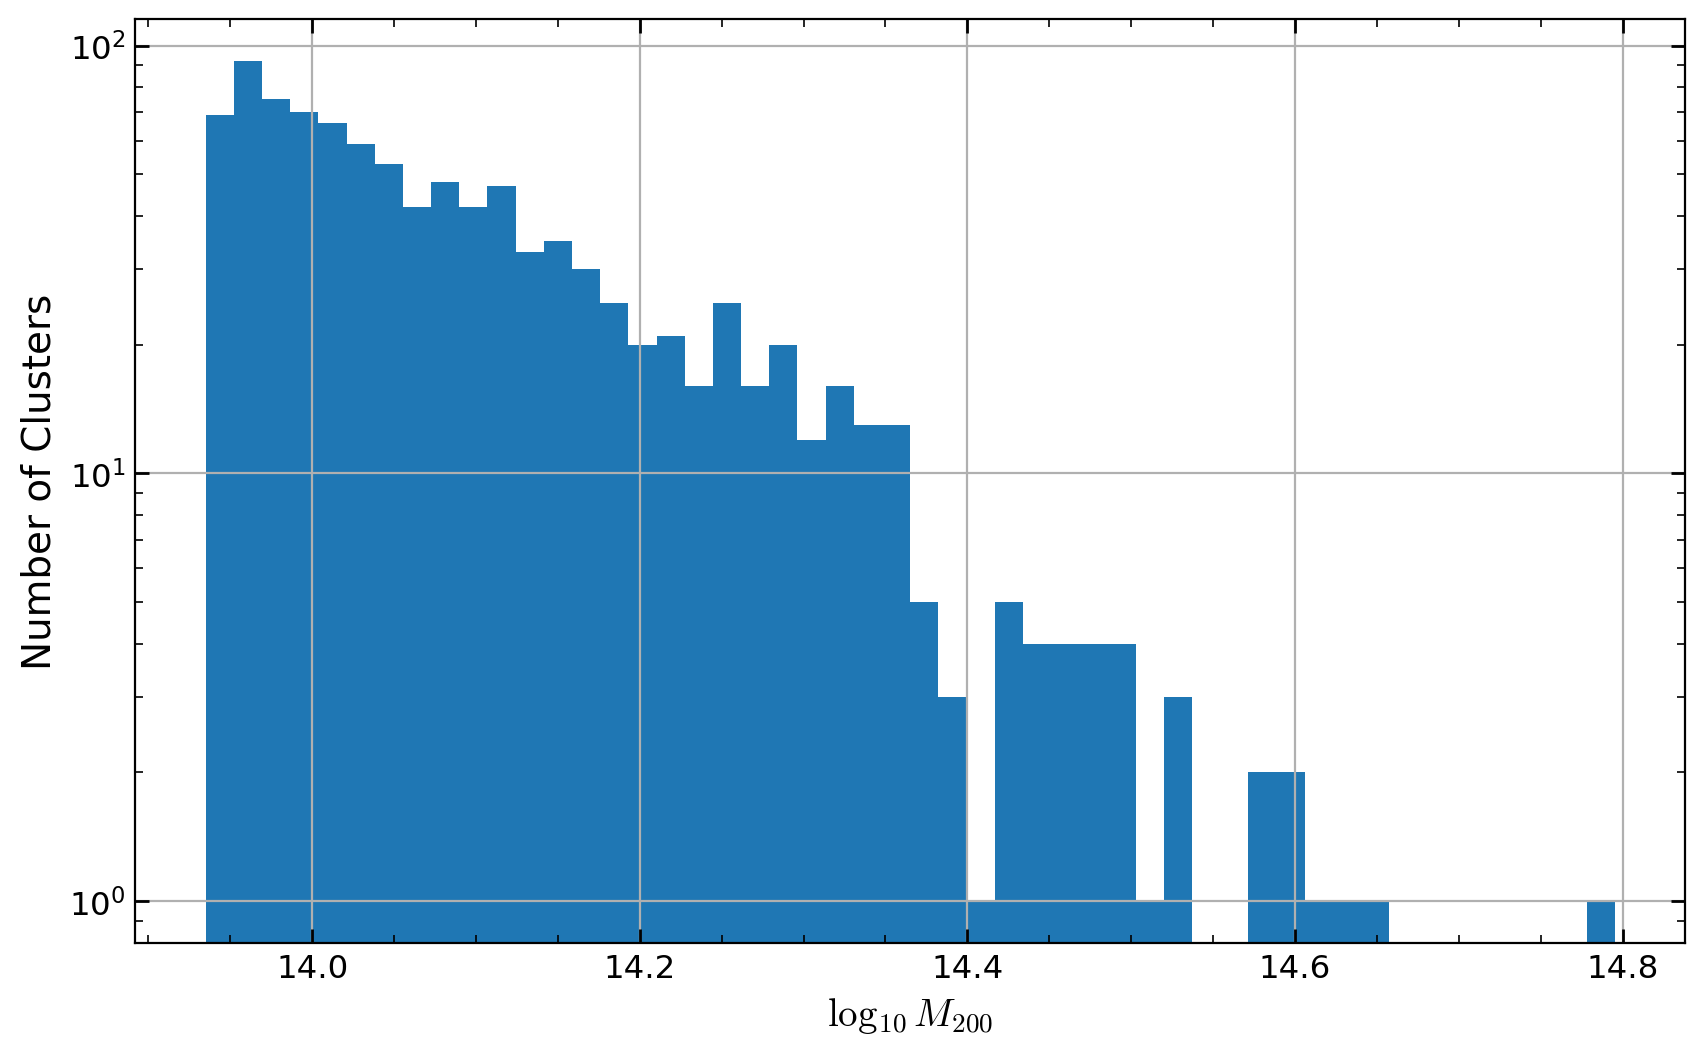

In [13]:
# plot theta distribution
plt.semilogy()
plt.hist(thetas_batch, bins=50)
plt.xlabel(r'$\log_{10} M_{200}$')
plt.ylabel('Number of Clusters');

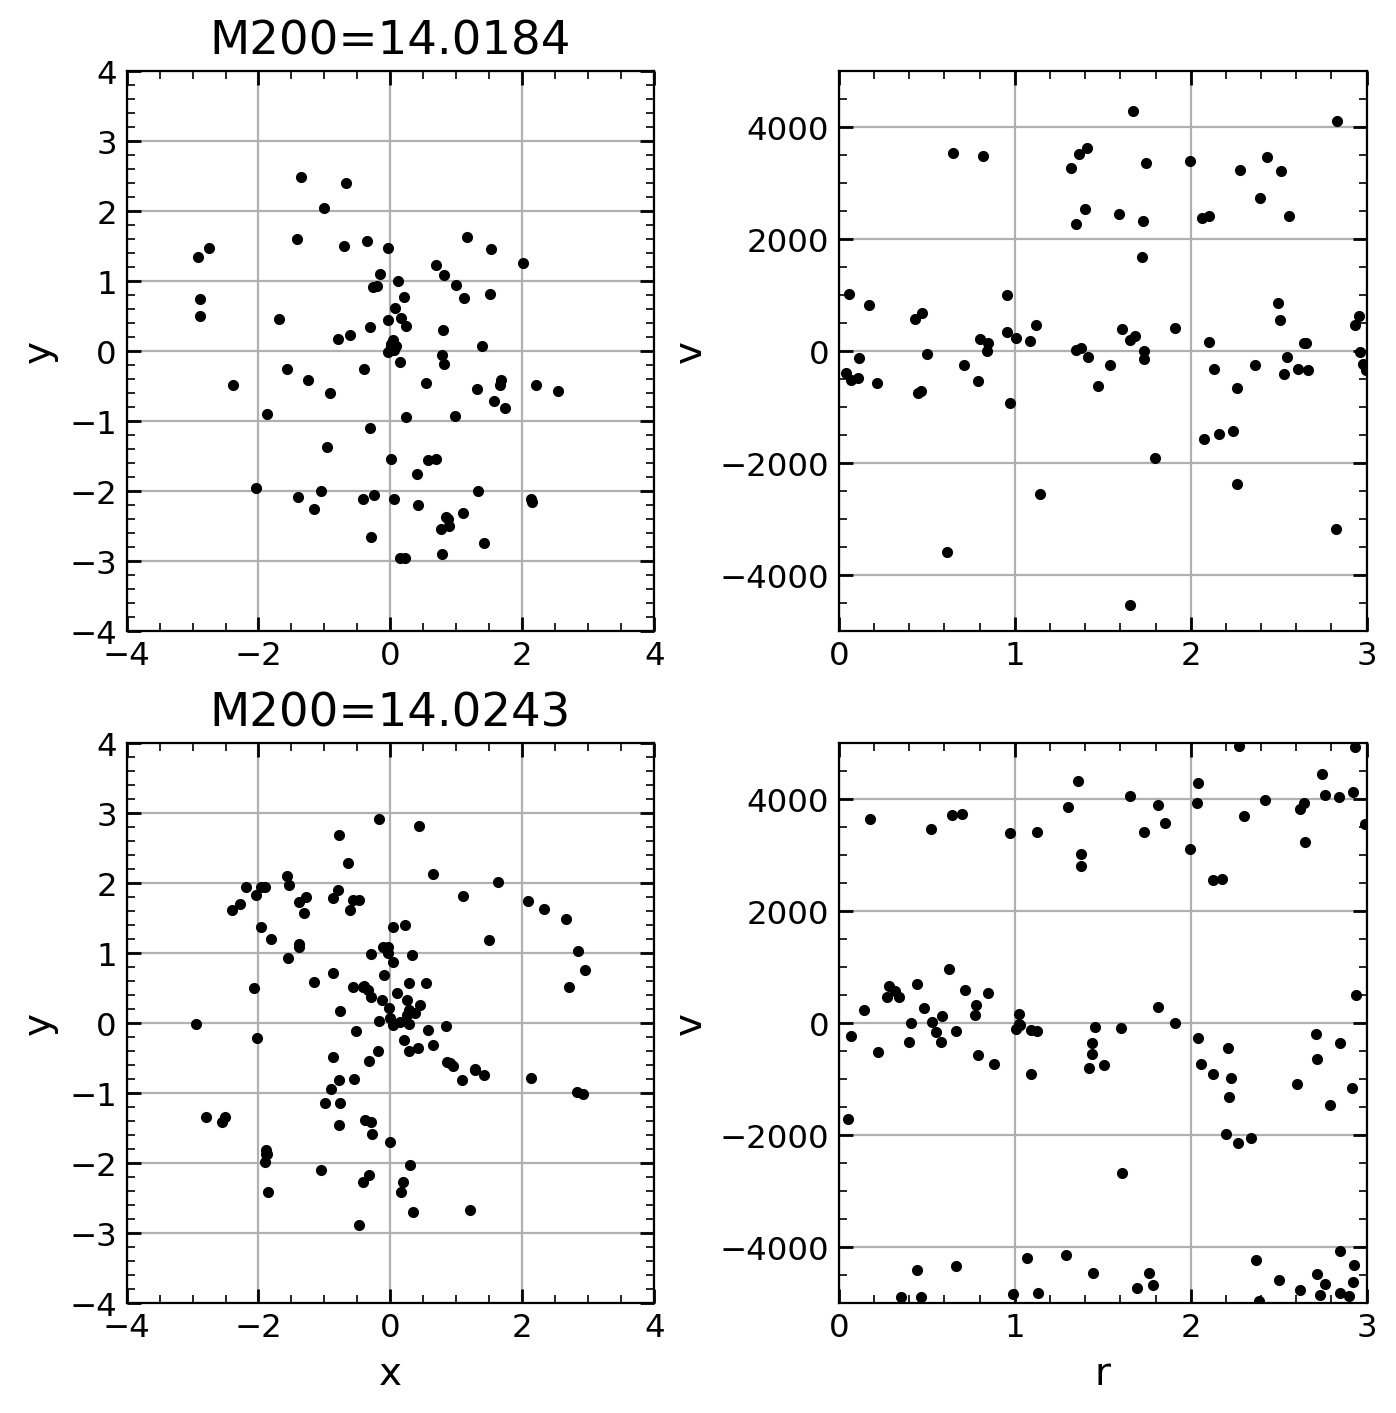

In [14]:
# plot example data
Nex = 2
f, axs = plt.subplots(Nex, 2, figsize=(8,4*Nex),
                      gridspec_kw={'wspace':0.35})
for i in range(Nex):
    ind = np.random.choice(len(x_batch))
    x = x_batch[ind]
    axs[i,0].plot(x[:,0], x[:,1], 'k.')
    axs[i,0].set_ylabel('y')
    axs[i,0].set_xlim(-4,4)
    axs[i,0].set_ylim(-4,4)
    axs[i,0].set_title(f'M200={thetas_batch[ind,0]:.4f}')
    if i==Nex-1:
        axs[i,0].set_xlabel('x')

    axs[i,1].plot(np.sqrt(x[:,0]**2 + x[:,1]**2), x[:,2], 'k.')
    axs[i,1].set_ylabel('v')
    axs[i,1].set_xlim(0,3)
    axs[i,1].set_ylim(-5000,5000)
    if i==Nex-1:
        axs[i,1].set_xlabel('r')
    

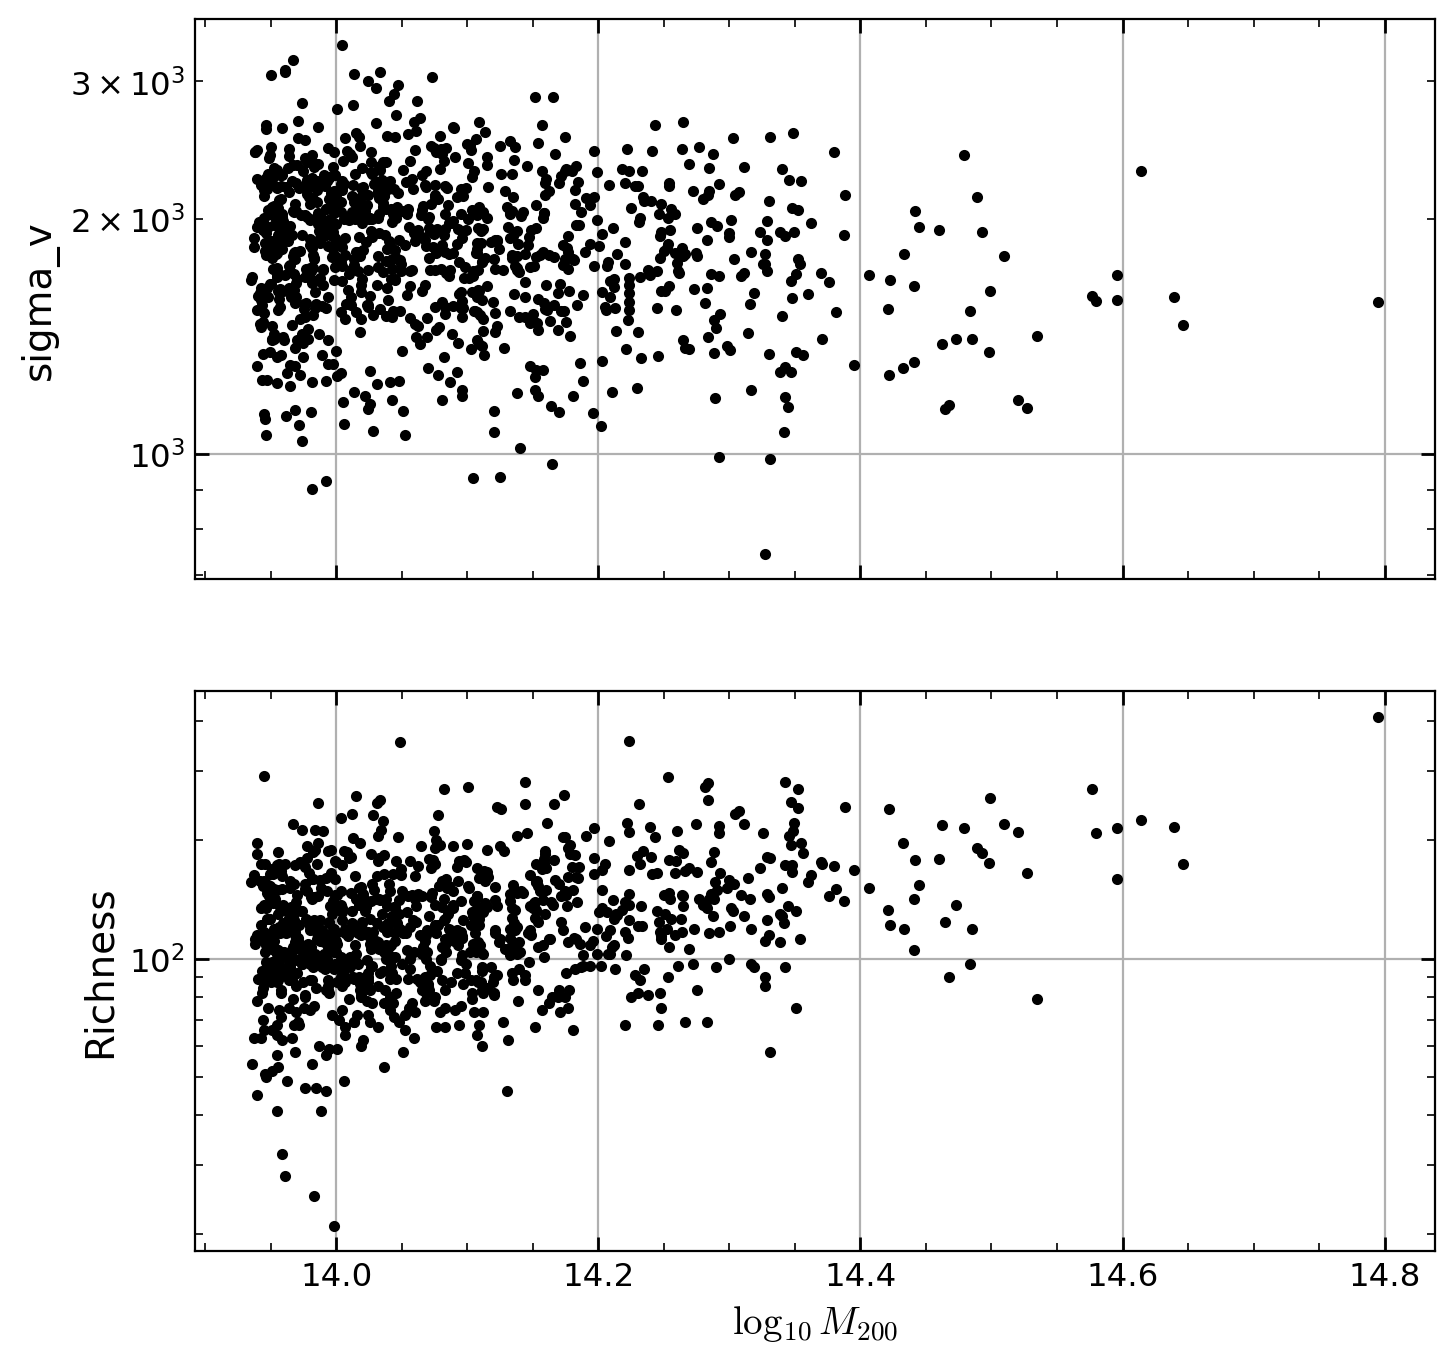

In [15]:
# plot summary relation
f, axs = plt.subplots(2, 1, figsize=(8,8), sharex=True)
axs[0].semilogy()
axs[0].plot(thetas_batch, x_sum[:,8], 'k.')
# axs[0].set_xlabel(r'$\log_{10} M_{200}$')
axs[0].set_ylabel('sigma_v');

axs[1].semilogy()
axs[1].plot(thetas_batch, x_sum[:,-1], 'k.')
axs[1].set_xlabel(r'$\log_{10} M_{200}$')
axs[1].set_ylabel('Richness');